# Analysis of RNA-seq Data for Different Gene Expression

## Load libraries

In [1]:
options(warn = -1)

suppressPackageStartupMessages({
  library(Rsamtools)
  library(GenomicAlignments)
  library(SummarizedExperiment)
  library(DESeq2)
  library(plyranges)
  library(tidyverse)
})

## Read transcript annotations

In [2]:
ensembl <- read_gff2("Homo_sapiens.GRCh38.108.ieg_subset.gtf") %>%
  print()

GRanges object with 748 ranges and 22 metadata columns:
        seqnames              ranges strand |         source            type
           <Rle>           <IRanges>  <Rle> |       <factor>        <factor>
    [1]        1 212565334-212620777      + | ensembl_havana      gene      
    [2]        1 212565334-212619535      + | havana              transcript
    [3]        1 212565334-212565483      + | havana              exon      
    [4]        1 212615018-212615261      + | havana              exon      
    [5]        1 212615022-212615261      + | havana              CDS       
    ...      ...                 ...    ... .            ...             ...
  [744]       14   75280783-75281587      + |         havana exon           
  [745]       14   75280783-75281421      + |         havana CDS            
  [746]       14   75281422-75281424      + |         havana stop_codon     
  [747]       14   75280193-75280610      + |         havana five_prime_utr 
  [748]       14   7

## Extract gene annotations

In [3]:
ensembl_subset <- ensembl %>%
  filter(type == "gene")  %>% 
  select(gene_name, gene_id)

## Assemble alignments for counting

In [4]:
bamfiles <- list.files("bamfiles/", recursive = T, full.names = T, pattern = ".bam$") %>%
  as_tibble_col("file") %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.bam)")) %>% 
  select(sample_name, file) %>%
  deframe() %>% 
  BamFileList() %>% 
  print()

BamFileList of length 12
names(12): fluc_1_2_rep1_0h fluc_1_2_rep1_6h ... gcn1_3_4_rep2_6h


## Count reads for each gene

In [5]:
expt <- summarizeOverlaps(ensembl_subset, bamfiles) %>%
  print()

class: RangedSummarizedExperiment 
dim: 6 12 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(2): gene_name gene_id
colnames(12): fluc_1_2_rep1_0h fluc_1_2_rep1_6h ... gcn1_3_4_rep2_0h
  gcn1_3_4_rep2_6h
colData names(0):


Look at assay, rowData, colnames, colData

## Extract sample annotations

In [6]:
colData <- colnames(expt) %>%
  as_tibble_col("sample_name") %>%
  separate(sample_name, c("knockdown", "sgrna1", "sgrna2", "replicate", "treatment"), remove = F) %>%
  column_to_rownames("sample_name") %>%
  print()

                 knockdown sgrna1 sgrna2 replicate treatment
fluc_1_2_rep1_0h      fluc      1      2      rep1        0h
fluc_1_2_rep1_6h      fluc      1      2      rep1        6h
fluc_1_2_rep2_0h      fluc      1      2      rep2        0h
fluc_1_2_rep2_6h      fluc      1      2      rep2        6h
gcn1_1_2_rep1_0h      gcn1      1      2      rep1        0h
gcn1_1_2_rep1_6h      gcn1      1      2      rep1        6h
gcn1_1_2_rep2_0h      gcn1      1      2      rep2        0h
gcn1_1_2_rep2_6h      gcn1      1      2      rep2        6h
gcn1_3_4_rep1_0h      gcn1      3      4      rep1        0h
gcn1_3_4_rep1_6h      gcn1      3      4      rep1        6h
gcn1_3_4_rep2_0h      gcn1      3      4      rep2        0h
gcn1_3_4_rep2_6h      gcn1      3      4      rep2        6h


## Modify colData in original data structure

In [7]:
expt <- SummarizedExperiment(assay = assay(expt), rowData = rowData(expt), colData = colData) 

expt

class: SummarizedExperiment 
dim: 6 12 
metadata(0):
assays(1): ''
rownames: NULL
rowData names(2): gene_name gene_id
colnames(12): fluc_1_2_rep1_0h fluc_1_2_rep1_6h ... gcn1_3_4_rep2_0h
  gcn1_3_4_rep2_6h
colData names(5): knockdown sgrna1 sgrna2 replicate treatment

## Read in full count data

In [8]:
deseq2_input <- read_csv("deseq2_input.csv.gz", show_col_types = F) %>%
  column_to_rownames("gene_name") %>%
  print()

             fluc_1_2_rep1_0h fluc_1_2_rep1_6h fluc_1_2_rep2_0h
AAAS                     1387             1734             1331
AACS                      423              815              397
AADAT                     205              314              151
AAGAB                    1489             1752             1342
AAK1                      495              790              524
AAMDC                     203              121              128
AAMP                     2428             2568             2444
AAR2                      903             1448              951
AARS1                    2880             2746             2989
AARS2                     756              774              819
AASDH                     317              612              299
AASDHPPT                  714              810              562
AASS                      300              331              228
AATF                     1583             2063             1446
ABCA2                     343           

## Run DESeq2

In [9]:
deseq2object <- DESeqDataSetFromMatrix(deseq2_input, colData = colData, design = ~ knockdown + treatment)

deseq2output <- DESeq(deseq2object)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



##  Examine DEseq2 results

In [10]:
resultsNames(deseq2output)

[1] "Intercept"              "knockdown_gcn1_vs_fluc" "treatment_6h_vs_0h"

In [11]:
treatment_effect <- results(deseq2output, contrast = c("treatment", "6h", "0h")) %>%
  print()

log2 fold change (MLE): treatment 6h vs 0h 
Wald test p-value: treatment 6h vs 0h 
DataFrame with 10771 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat      pvalue        padj
       <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
AAAS    1536.361      0.0968785 0.0609443   1.58962 1.11920e-01 1.52767e-01
AACS     507.061      0.6649000 0.0790927   8.40659 4.22097e-17 3.84636e-16
AADAT    187.660      0.4138504 0.1116181   3.70774 2.09121e-04 4.89449e-04
AAGAB   1413.408     -0.0269435 0.0627425  -0.42943 6.67611e-01 7.17290e-01
AAK1     603.854      0.2661999 0.0879223   3.02767 2.46446e-03 4.79666e-03
...          ...            ...       ...       ...         ...         ...
PTGS2    102.630      -0.143557  0.102347 -1.402648   0.1607218   0.2094790
SCG3     101.875      -0.164540  0.100861 -1.631358   0.1028148   0.1418065
SNX16    103.973      -0.107694  0.107774 -0.999255   0.3176713   0.3806048
TCIM     101.203      -0.183674  0.100307

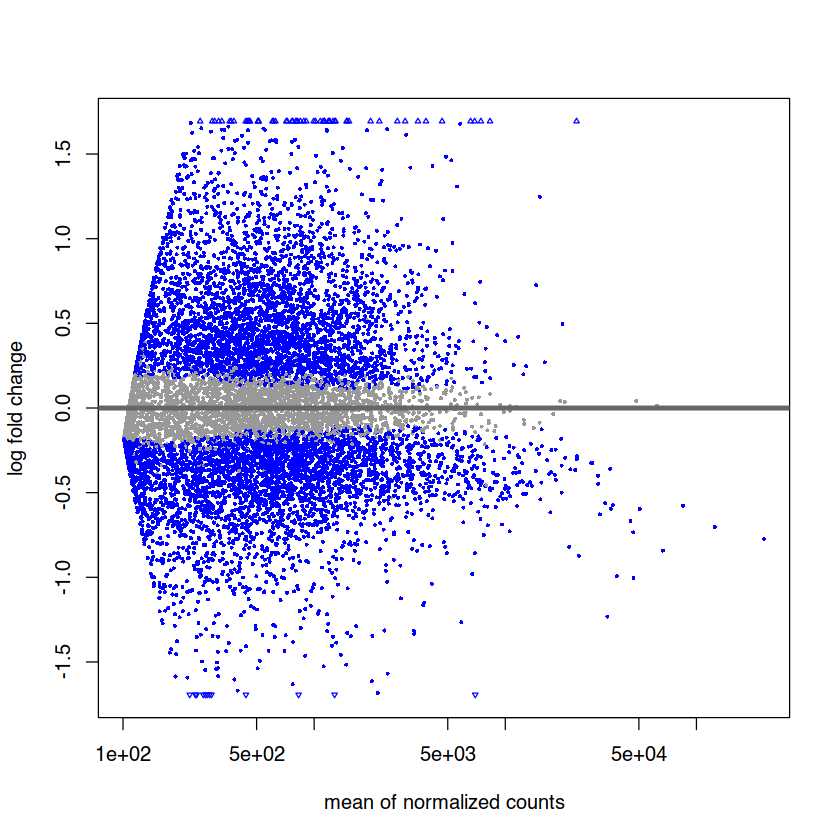

In [12]:
plotMA(treatment_effect)

In [13]:
knockdown_effect <- results(deseq2output, contrast = c("knockdown", "gcn1", "fluc")) %>%
  print()

log2 fold change (MLE): knockdown gcn1 vs fluc 
Wald test p-value: knockdown gcn1 vs fluc 
DataFrame with 10771 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat      pvalue       padj
       <numeric>      <numeric> <numeric> <numeric>   <numeric>  <numeric>
AAAS    1536.361      0.2169240 0.0646699  3.354329 0.000795578 0.00886381
AACS     507.061     -0.0906681 0.0831407 -1.090537 0.275476544 0.44091275
AADAT    187.660     -0.4451401 0.1159057 -3.840538 0.000122765 0.00249289
AAGAB   1413.408     -0.0346465 0.0663454 -0.522213 0.601521775 0.73635524
AAK1     603.854      0.1479569 0.0931788  1.587881 0.112313170 0.24027784
...          ...            ...       ...       ...         ...        ...
PTGS2    102.630       0.203801  0.108804   1.87311   0.0610532   0.157664
SCG3     101.875       0.187296  0.107100   1.74880   0.0803254         NA
SNX16    103.973       0.232877  0.114755   2.02933   0.0424243   0.125122
TCIM     101.203       0.172555  0.106392   

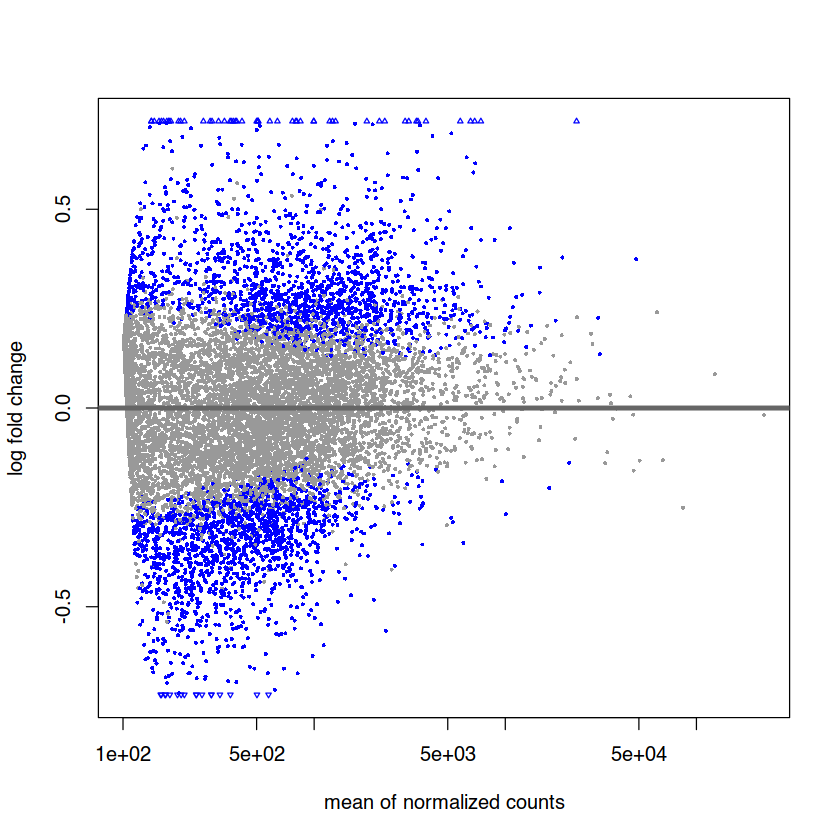

In [14]:
plotMA(knockdown_effect)

## What is the effect of knockdown on treatment?

In [15]:
deseq2object <- DESeqDataSetFromMatrix(deseq2_input, colData = colData, design = ~ knockdown + treatment + knockdown:treatment)

deseq2output <- DESeq(deseq2object)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [16]:
resultsNames(deseq2output)

[1] "Intercept"                 "knockdown_gcn1_vs_fluc"   
[3] "treatment_6h_vs_0h"        "knockdowngcn1.treatment6h"

In [17]:
knockdown_treatment_effect <- results(deseq2output, name = 'knockdowngcn1.treatment6h') %>%
  print()

log2 fold change (MLE): knockdowngcn1.treatment6h 
Wald test p-value: knockdowngcn1.treatment6h 
DataFrame with 10771 rows and 6 columns
        baseMean log2FoldChange     lfcSE       stat    pvalue      padj
       <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
AAAS    1536.361     0.06851669  0.140934  0.4861615 0.6268526  0.827216
AACS     507.061     0.01742753  0.174766  0.0997193 0.9205672  0.969774
AADAT    187.660    -0.38671280  0.219114 -1.7648967 0.0775811  0.273064
AAGAB   1413.408    -0.10058421  0.142773 -0.7045028 0.4811197  0.735968
AAK1     603.854    -0.00427982  0.196607 -0.0217684 0.9826327  0.994447
...          ...            ...       ...        ...       ...       ...
PTGS2    102.630      0.1264641  0.251896   0.502049  0.615633        NA
SCG3     101.875      0.0951636  0.247518   0.384472  0.700628        NA
SNX16    103.973      0.1799446  0.266048   0.676360  0.498812        NA
TCIM     101.203      0.0664979  0.245939   0.270383  0.7868

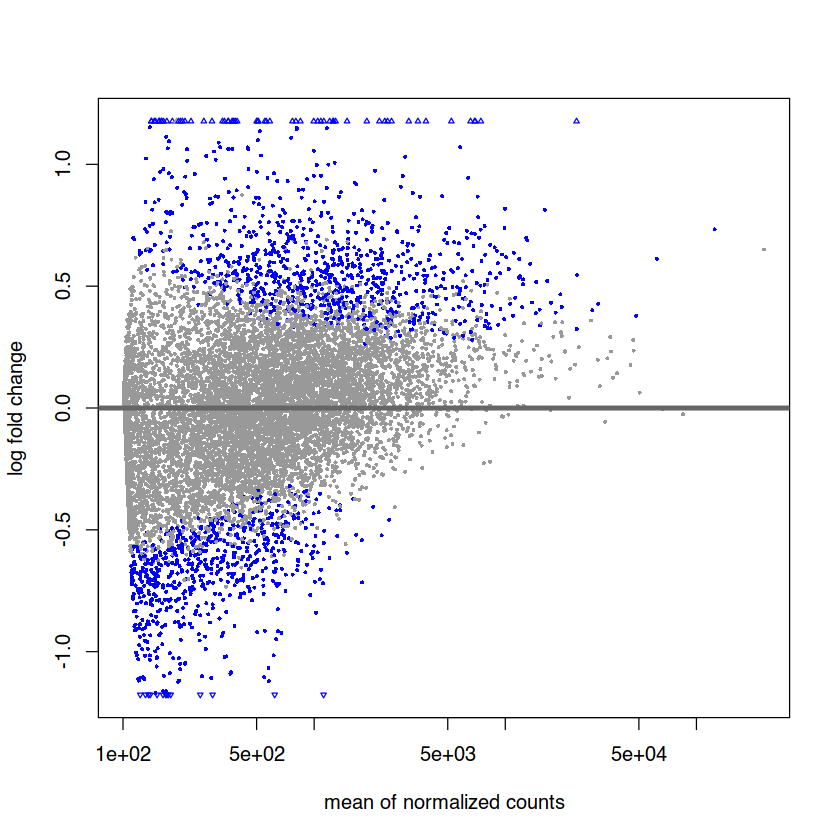

In [18]:
plotMA(knockdown_treatment_effect)